In [ ]:
import os
import imageio.v2 as imageio
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product
import random
from keras import backend as K
import gc
from tqdm import tqdm
from keras.layers import *
from sklearn.utils import shuffle
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 #update the directory with you drive location of the dataset
directory = "/content/drive/My Drive/CI_DataSet/cancer_dataset/dataset"
classes = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
sizeData = {}
imagesData={}
imagesPath=[]
imagesClass=[]
for class_name in classes:
    path = os.path.join(directory, class_name)
    temp_dict = {}
    counter=0
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        try:
            height, width, channels = imageio.imread(filepath).shape
            imagesPath.append(filepath)
            imagesClass.append(class_name)
            dimension = f'{height} x {width}'
            if dimension in temp_dict:
                temp_dict[dimension] += 1
            else:
                temp_dict[dimension] = 1
        except Exception as e:
            print(f"Failed to process {filepath}: {e}")

    sizeData[class_name] = temp_dict
    imagesData = pd.DataFrame({"Image_Path":imagesPath,"Class":imagesClass})


sizeData

<ipython-input-9-c7bd82973291>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

<ipython-input-10-afd465346bf6>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


RGB


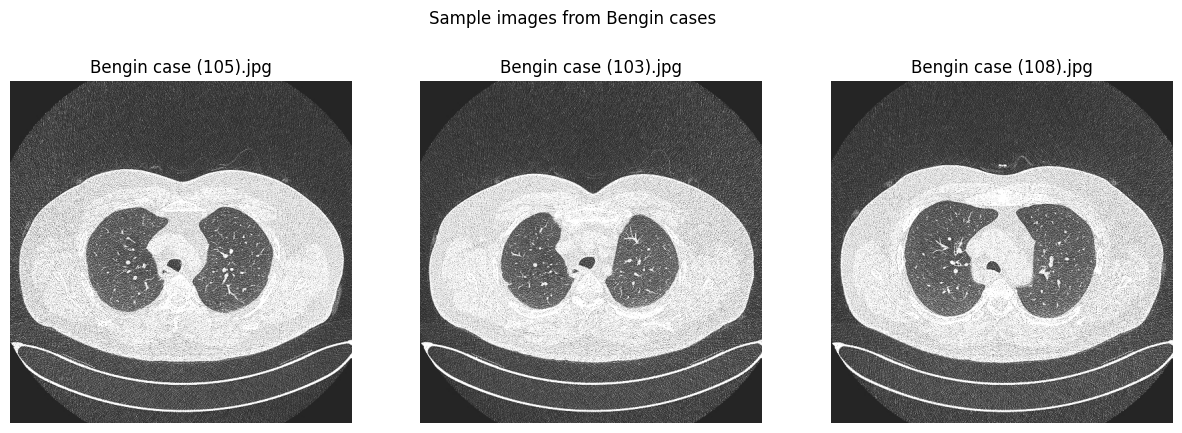

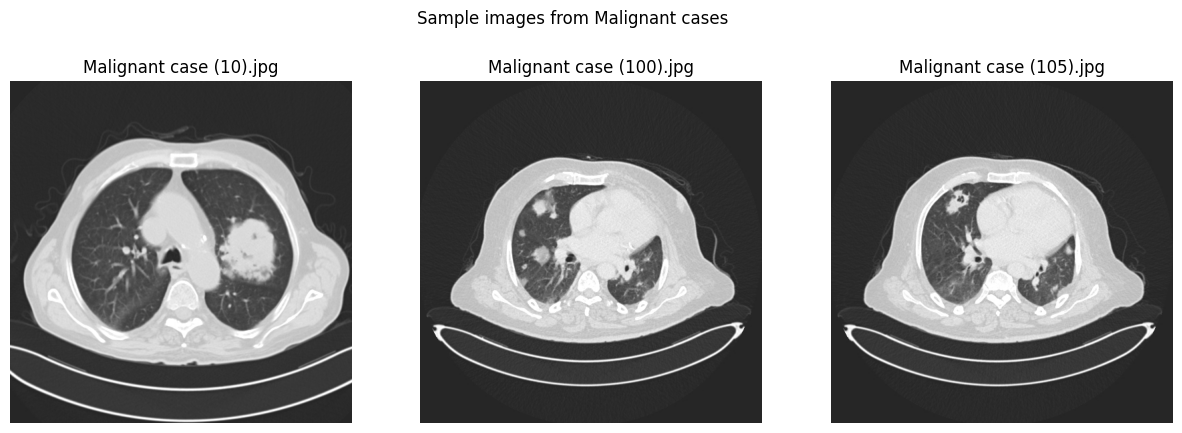

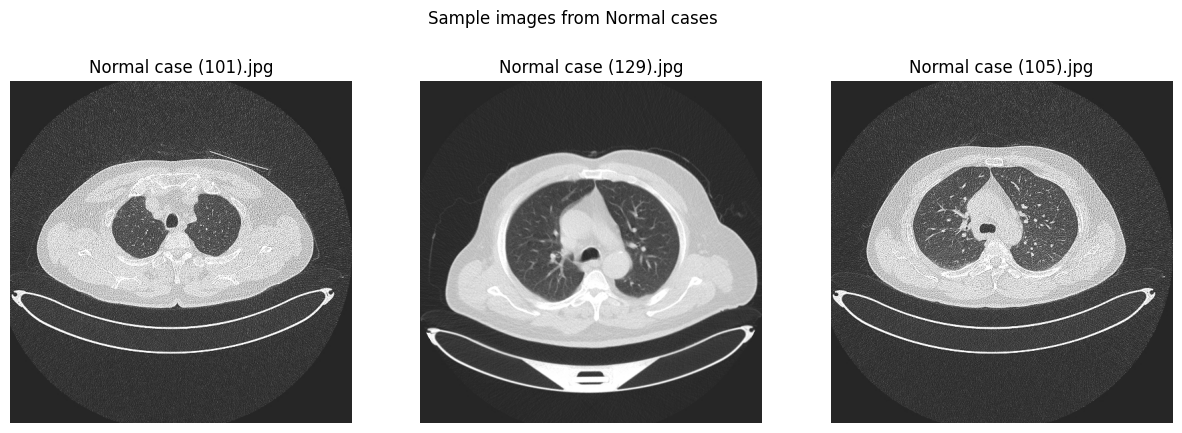

In [ ]:
show=True
for label in imagesData['Class'].unique():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample images from {label}')
    sample_images = imagesData[imagesData['Class'] == label]['Image_Path'].head(3)
    for ax, img_path in zip(axes, sample_images):
        image = imageio.imread(img_path)
        if show:
          if image.ndim == 2:
            print("Grayscale")
          elif image.ndim == 3 and image.shape[2] == 3:
            print( "RGB")
          elif image.ndim == 3 and image.shape[2] == 4:
            print( "RGBA")
          show=False
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(os.path.basename(img_path))
    plt.show()

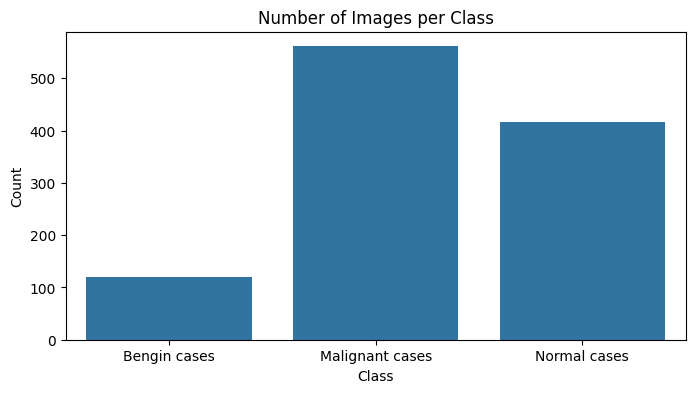

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=imagesData, x='Class')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

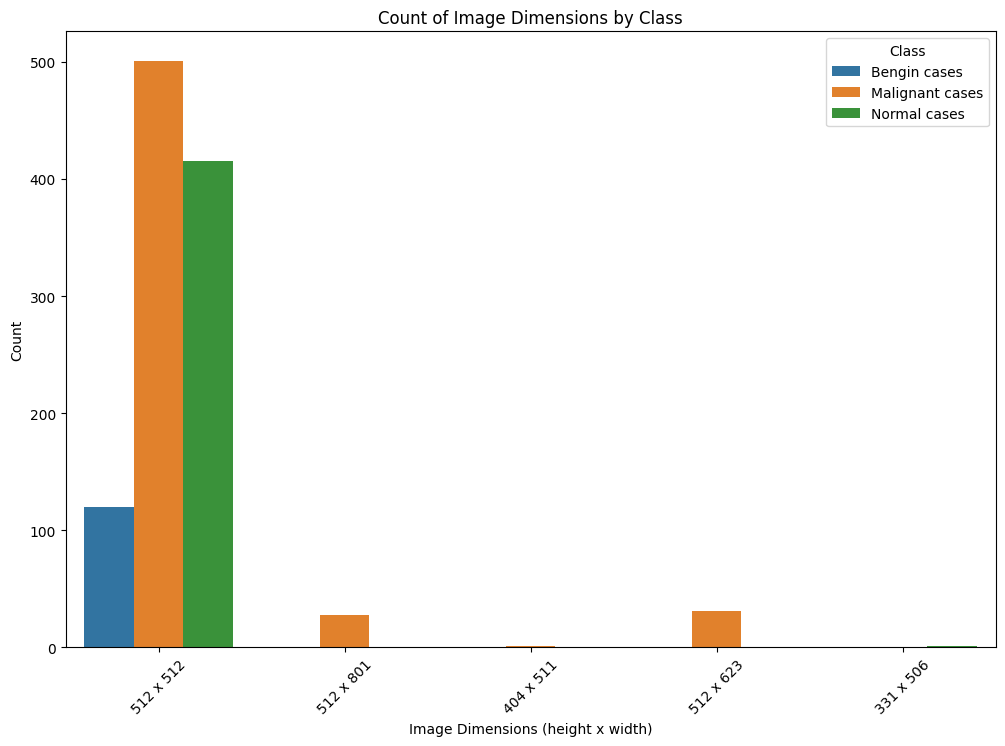

In [ ]:
data = []
for class_name, dimensions in sizeData.items():
    for dimension, count in dimensions.items():
        data.append({'Class': class_name, 'Dimension': dimension, 'Count': count})
df = pd.DataFrame(data)


plt.figure(figsize=(12, 8))
sns.barplot(x='Dimension', y='Count', hue='Class', data=df)
plt.title('Count of Image Dimensions by Class')
plt.xlabel('Image Dimensions (height x width)')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate dimension labels for better readability
plt.legend(title='Class')
plt.show()

In [ ]:
imagesData


,Image_Path,Class
0,/content/drive/My Drive/CI_DataSet/cancer_data...,Bengin cases
1,/content/drive/My Drive/CI_DataSet/cancer_data...,Bengin cases
2,/content/drive/My Drive/CI_DataSet/cancer_data...,Bengin cases
3,/content/drive/My Drive/CI_DataSet/cancer_data...,Bengin cases
4,/content/drive/My Drive/CI_DataSet/cancer_data...,Bengin cases
...,...,...
1092,/content/drive/My Drive/CI_DataSet/cancer_data...,Normal cases
1093,/content/drive/My Drive/CI_DataSet/cancer_data...,Normal cases
1094,/content/drive/My Drive/CI_DataSet/cancer_data...,Normal cases
1095,/content/drive/My Drive/CI_DataSet/cancer_data...,Normal cases


In [ ]:
def loadImages(image_paths, size=(64, 64)):
    images = []
    for path in image_paths:
        img = imread(path)
        img = resize(img, size)
        images.append(img)
    images = np.array(images)
    return images / 255.0

In [ ]:
X = loadImages(imagesData['Image_Path'].tolist())
y = pd.get_dummies(imagesData['Class']).values
X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(767, 64, 64, 3)

## Oversampling the minority class(Bengin Cases)

In [ ]:
X_sampled = loadImages(imagesData['Image_Path'].tolist())
y_sampled= pd.get_dummies(imagesData['Class']).values

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)
X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(X_train_sampled, y_train_sampled, test_size=0.25, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(X_train_sampled, y_train_sampled, batch_size=32)

In [ ]:
class_totals = y_train_sampled.sum(axis=0)
minority_class_index = np.argmin(class_totals)
max_samples = np.max(class_totals)

num_augmented_images = (max_samples - class_totals[minority_class_index]) // class_totals[minority_class_index]
minority_indices = np.where(y_train_sampled[:, minority_class_index] == 1)[0]

augmented_images = []
augmented_labels = []

for i in minority_indices:
    x = X_train_sampled[i]
    x = x.reshape((1,) + x.shape)

    for _ in range(num_augmented_images):
        for x_aug in train_datagen.flow(x, batch_size=1):
            augmented_images.append(x_aug[0])
            label = np.zeros((y_train_sampled.shape[1],))
            label[minority_class_index] = 1
            augmented_labels.append(label)
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

X_train_balanced = np.concatenate((X_train_sampled, augmented_images), axis=0)
y_train_balanced = np.concatenate((y_train_sampled, augmented_labels), axis=0)

indices = np.arange(X_train_balanced.shape[0])
np.random.shuffle(indices)
X_train_balanced = X_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]

In [ ]:
train_generator = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=32)

## Basic CNN Model

In [ ]:
model_cnn = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

Epoch 1/30
20/20 [==============================] - 14s 585ms/step - loss: 1.0002 - accuracy: 0.4666 - val_loss: 0.9643 - val_accuracy: 0.4675
Epoch 2/30
20/20 [==============================] - 13s 640ms/step - loss: 0.9652 - accuracy: 0.4943 - val_loss: 0.9664 - val_accuracy: 0.4675
Epoch 3/30
20/20 [==============================] - 13s 638ms/step - loss: 0.9630 - accuracy: 0.5155 - val_loss: 0.9782 - val_accuracy: 0.4675
Epoch 4/30
20/20 [==============================] - 14s 723ms/step - loss: 0.9661 - accuracy: 0.5008 - val_loss: 0.9686 - val_accuracy: 0.4675
Epoch 5/30
20/20 [==============================] - 13s 651ms/step - loss: 0.9483 - accuracy: 0.5188 - val_loss: 0.9666 - val_accuracy: 0.4675
Epoch 6/30
20/20 [==============================] - 12s 610ms/step - loss: 0.9605 - accuracy: 0.5057 - val_loss: 0.9897 - val_accuracy: 0.4675
Epoch 7/30
20/20 [==============================] - 11s 535ms/step - loss: 0.9529 - accuracy: 0.5122 - val_loss: 0.9740 - val_accuracy: 0.4675

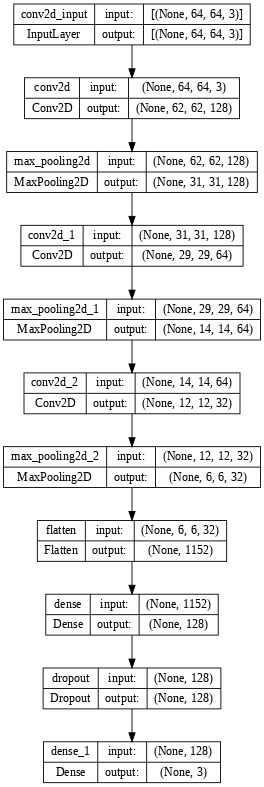

In [ ]:
tf.keras.utils.plot_model(model_cnn, show_shapes=True, dpi=64)

In [ ]:
predictions = model_cnn.predict(X_test)
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f"Test accuracy for CNN: {accuracy_cnn*100:.2f}%")

11/11 [==============================] - 4s 395ms/step - loss: 0.9643 - accuracy: 0.5273
Test accuracy for CNN: 52.73%


## Fuzzy neural Network with Convolutional Layers

In [ ]:
n_feature = 9
n_neurons = 128
rows, cols= 64, 64

fRules = list(product([-1.0,0.0,1.0], repeat=n_feature))

out_fRules = random.sample(fRules, n_neurons)
out_fRules_tensor = tf.constant(out_fRules)

fRules_sigma = tf.transpose(out_fRules_tensor)

In [ ]:
class fuzzy_inference_block(tf.keras.layers.Layer):
    def __init__(self, output_dim, i_fmap, mu, sigma, total_features):
        super(fuzzy_inference_block, self).__init__()
        self.output_dim = output_dim
        self.index = i_fmap
        self.mu = mu
        self.sigma = sigma
        self.total_features = total_features

    def build(self, input_shape):
        # Calculate features per block based on the total features and n_feature
        self.feature_per_block = self.total_features // n_feature
        self.mu_map = self.add_weight(shape=(self.feature_per_block, self.output_dim), initializer="random_normal", trainable=True)
        self.sigma_map = self.add_weight(shape=(self.feature_per_block, self.output_dim), initializer="constant", trainable=True)

    def call(self, inputs):
        # Adjust slicing to match the features per block
        start_index = self.index * self.feature_per_block
        end_index = (self.index + 1) * self.feature_per_block
        fMap = inputs[:, start_index:end_index]
        fMap = tf.reshape(fMap, (-1, self.feature_per_block, 1))
        aligned_x = tf.repeat(fMap, self.output_dim, axis=-1)
        phi = tf.exp(-tf.reduce_sum(tf.square(aligned_x - self.mu_map) / (2 * tf.square(self.sigma_map)), axis=1))
        return phi

In [ ]:
def fcnn(n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=True):
    num_classes = 3
    inp = Input(shape=(64, 64, 3))

    conv1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inp)
    conv1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv1)

    conv2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(conv1)
    conv2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv2)

    conv3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv2)
    conv3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv3)

    conv4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv3)
    conv4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv4)

    conv5 = Conv2D(n_femap, (4, 4), padding='same', strides=(stride,stride), activation='relu')(conv4)
    if dropout:
       conv5 = Dropout(0.2)(conv5)

    fMaps = Flatten()(conv5)
    total_features = fMaps.shape[1]  # Ensure this calculation is correct

    fuzzy_inference = [fuzzy_inference_block(output_dim=n_neurons, i_fmap=i, mu=mu, sigma=sigma, total_features=total_features)(fMaps) for i in range(n_femap)]
    merged = concatenate(fuzzy_inference, axis=1)

    out = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=inp, outputs=out)
    return model

In [ ]:
model_fcnn = fcnn(n_femap=4)
model_fcnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_fcnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 20, 20, 20)           2180      ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_29 (MaxPooli  (None, 20, 20, 20)           0         ['conv2d_34[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 8, 8, 40)             28840     ['max_pooling2d_29[0][0]

In [ ]:
history = model_fcnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 5s 85ms/step - loss: 1.0662 - accuracy: 0.4290 - val_loss: 1.0172 - val_accuracy: 0.4675
Epoch 2/10
20/20 [==============================] - 1s 46ms/step - loss: 0.9598 - accuracy: 0.5008 - val_loss: 0.9678 - val_accuracy: 0.4675
Epoch 3/10
20/20 [==============================] - 1s 46ms/step - loss: 0.9705 - accuracy: 0.4812 - val_loss: 1.0933 - val_accuracy: 0.4675
Epoch 4/10
20/20 [==============================] - 1s 43ms/step - loss: 0.9792 - accuracy: 0.4959 - val_loss: 1.0320 - val_accuracy: 0.4675
Epoch 5/10
20/20 [==============================] - 1s 42ms/step - loss: 0.9699 - accuracy: 0.4715 - val_loss: 0.9681 - val_accuracy: 0.4221
Epoch 6/10
20/20 [==============================] - 1s 44ms/step - loss: 1.0000 - accuracy: 0.4519 - val_loss: 0.9866 - val_accuracy: 0.4675
Epoch 7/10
20/20 [==============================] - 1s 41ms/step - loss: 0.9595 - accuracy: 0.4959 - val_loss: 0.9973 - val_accuracy: 0.4675
Epoch 8/10
20

In [ ]:
predictions = model_fcnn.predict(X_test)
loss_fcnn, accuracy_fcnn = model_fcnn.evaluate(X_test, y_test)
print(f"Test accuracy for Fuzzy neural Network: {accuracy_fcnn*100:.2f}%")

11/11 [==============================] - 0s 20ms/step - loss: 0.9899 - accuracy: 0.3515
Test accuracy for Fuzzy neural Network: 35.15%


## Optimzation of CNN



In [ ]:
train_generator_balanced = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=32)

In [ ]:
model_cnn_sampled = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model_cnn_sampled.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model_cnn, show_shapes=True, dpi=64)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

history = model_cnn_sampled.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=[early_stopping, reduce_lr])

Epoch 1/50
20/20 [==============================] - 9s 328ms/step - loss: 0.9990 - accuracy: 0.4715 - val_loss: 0.9788 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 4s 204ms/step - loss: 0.9852 - accuracy: 0.4731 - val_loss: 0.9770 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 4s 200ms/step - loss: 0.9620 - accuracy: 0.5122 - val_loss: 0.9703 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 6s 289ms/step - loss: 0.9472 - accuracy: 0.5041 - val_loss: 0.9641 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 4s 197ms/step - loss: 0.9582 - accuracy: 0.4927 - val_loss: 0.9717 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 4s 198ms/step - loss: 0.9585 - accuracy: 0.5024 - val_loss: 0.9681 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 5s 260ms/step - lo

In [ ]:

predictions = model_cnn_sampled.predict(X_test)
# Evaluate the model
loss_cnn_opt, accuracy_cnn_opt = model_cnn_sampled.evaluate(X_test, y_test)
print(f"Test accuracy for CNN after optimzation: {accuracy_cnn_opt*100:.2f}%")

11/11 [==============================] - 1s 53ms/step - loss: 0.4147 - accuracy: 0.8121
Test accuracy for CNN after optimzation: 81.21%


## ANN basic model

In [ ]:
model_ann = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ann.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
20/20 [==============================] - 3s 112ms/step - loss: 0.9775 - accuracy: 0.4976 - val_loss: 0.9376 - val_accuracy: 0.4675
Epoch 2/30
20/20 [==============================] - 3s 130ms/step - loss: 0.9060 - accuracy: 0.5465 - val_loss: 0.9021 - val_accuracy: 0.4675
Epoch 3/30
20/20 [==============================] - 3s 138ms/step - loss: 0.8697 - accuracy: 0.5775 - val_loss: 0.8366 - val_accuracy: 0.6169
Epoch 4/30
20/20 [==============================] - 2s 96ms/step - loss: 0.8185 - accuracy: 0.6297 - val_loss: 0.7923 - val_accuracy: 0.6104
Epoch 5/30
20/20 [==============================] - 2s 80ms/step - loss: 0.7776 - accuracy: 0.6509 - val_loss: 0.7592 - val_accuracy: 0.6688
Epoch 6/30
20/20 [==============================] - 2s 93ms/step - loss: 0.7601 - accuracy: 0.6737 - val_loss: 0.7445 - val_accuracy: 0.6688
Epoch 7/30
20/20 [==============================] - 2s 106ms/step - loss: 0.6965 - accuracy: 0.6966 - val_loss: 0.6872 - val_accuracy: 0.7403
Epoch 8/3

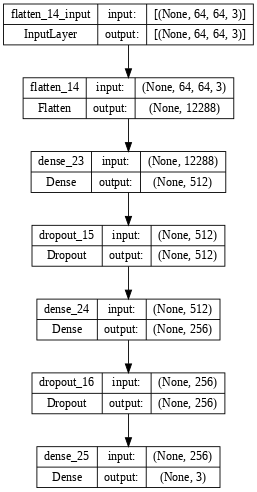

In [ ]:
tf.keras.utils.plot_model(model_ann, show_shapes=True, dpi=64)

In [ ]:
predictions = model_ann.predict(X_test)
# Evaluate the model
loss_ann, accuracy_ann = model_ann.evaluate(X_test, y_test)
print(f"Test accuracy for ANN is : {accuracy_ann*100:.2f}%")

11/11 [==============================] - 0s 15ms/step - loss: 0.3387 - accuracy: 0.8576
Test accuracy for ANN is : 85.76%


## ANN model after optimzation

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
history = model_ann.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,callbacks=[early_stopping, reduce_lr])

Epoch 1/30
20/20 [==============================] - 4s 212ms/step - loss: 0.2186 - accuracy: 0.9103 - val_loss: 0.3125 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 3s 132ms/step - loss: 0.2170 - accuracy: 0.9250 - val_loss: 0.3410 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 2s 119ms/step - loss: 0.1948 - accuracy: 0.9331 - val_loss: 0.3030 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 2s 98ms/step - loss: 0.2175 - accuracy: 0.9103 - val_loss: 0.3103 - val_accuracy: 0.8896 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 2s 97ms/step - loss: 0.2565 - accuracy: 0.8989 - val_loss: 0.2939 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 3s 128ms/step - loss: 0.2486 - accuracy: 0.8972 - val_loss: 0.3439 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 2s 115ms/step - loss

In [ ]:
predictions = model_ann.predict(X_test)
# Evaluate the model
loss_ann_opt, accuracy_ann_opt = model_ann.evaluate(X_test, y_test)
print(f"Test accuracy for ANN after optimzation is : {accuracy_ann_opt*100:.2f}%")

11/11 [==============================] - 0s 26ms/step - loss: 0.1326 - accuracy: 0.9727
Test accuracy for ANN after optimzation is : 97.27%


## MLP Model using optimzation

In [ ]:


model_mlp = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_mlp.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping, reduce_lr])

predictions = model_mlp.predict(X_test)
# Evaluate the model
loss_mlp, accuracy_mlp = model_mlp.evaluate(X_test, y_test)
print(f"Test accuracy for by using MLP with optimzation is  : {accuracy_mlp*100:.2f}%")


Epoch 1/30
20/20 [==============================] - 5s 163ms/step - loss: 0.9711 - accuracy: 0.4976 - val_loss: 0.9393 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 3s 156ms/step - loss: 0.9073 - accuracy: 0.5481 - val_loss: 0.8782 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 3s 128ms/step - loss: 0.8439 - accuracy: 0.5954 - val_loss: 0.8116 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 2s 90ms/step - loss: 0.7989 - accuracy: 0.6199 - val_loss: 0.7774 - val_accuracy: 0.6753 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 2s 86ms/step - loss: 0.7720 - accuracy: 0.6623 - val_loss: 0.7815 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 2s 105ms/step - loss: 0.7703 - accuracy: 0.6688 - val_loss: 0.7263 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 2s 97ms/step - loss:

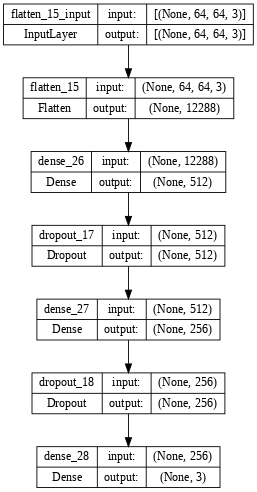

In [ ]:
tf.keras.utils.plot_model(model_mlp, show_shapes=True, dpi=64)

## RESNET 50 on balanced data and optimzation

In [ ]:
def loadImagesForResnet(imagePaths, size=(224,224)):
    images = []
    for path in imagePaths:
        img = imread(path)
        img = resize(img, size, anti_aliasing=True)
        if img.ndim == 2:
            img = np.stack((img,)*3, axis=-1)
        elif img.shape[2] == 4:
            img = img[..., :3]
        images.append(img)

    images = np.array(images)
    images = preprocess_input(images)
    return images

In [ ]:
X_resnet = loadImagesForResnet(imagesData['Image_Path'].tolist())
y_resnet = pd.get_dummies(imagesData['Class']).values

X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = train_test_split(X_resnet, y_resnet, test_size=0.3, random_state=42)

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet = model_resnet.fit(X_train_resnet, y_train_resnet, epochs=10,validation_split=0.2)


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
20/20 [==============================] - 187s 9s/step - loss: 1.3646 - accuracy: 0.4470 - val_loss: 1.0165 - val_accuracy: 0.4610
Epoch 2/10
20/20 [==============================] - 175s 9s/step - loss: 0.9903 - accuracy: 0.5237 - val_loss: 0.8564 - val_accuracy: 0.6039
Epoch 3/10
20/20 [==============================] - 242s 12s/step - loss: 0.7981 - accuracy: 0.6476 - val_loss: 0.8056 - val_accuracy: 0.6688
Epoch 4/10
20/20 [==============================] - 204s 10s/step - loss: 0.7862 - accuracy: 0.6460 - val_loss: 0.8755 - val_accuracy: 0.5584
Epoch 5/10
20/20 [==============================] - 178s 9s/step - loss: 0.7534 - accuracy: 0.6509 - val_loss: 0.7632 - val_accuracy: 0.6688
Epoch 6/10
20/20 [==============================] - 176s 9s/step - loss: 0.7046 - accuracy: 0.6705 - val_loss: 0.7685 - val_accuracy: 0.7013
Epoch 7/10
20/20 [==============================] - 168s 8s/step - loss: 0.7616 - accur

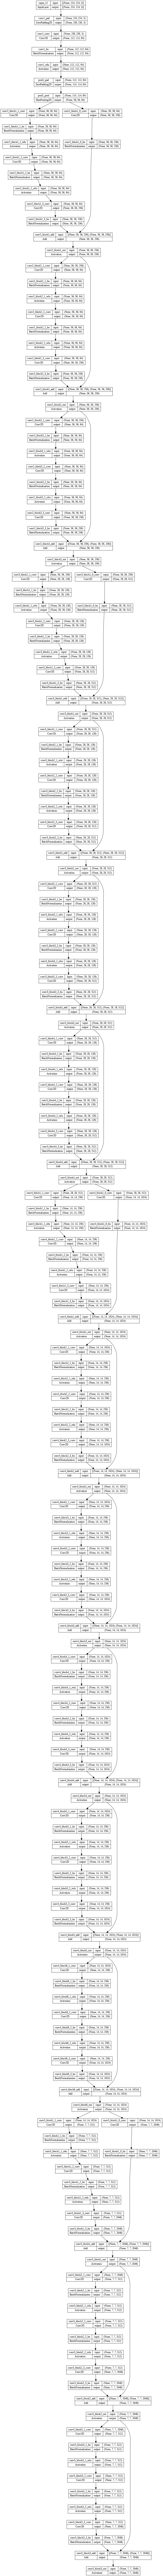

In [ ]:
tf.keras.utils.plot_model(base_model_resnet, show_shapes=True, dpi=64)

In [ ]:
predictions = model_resnet.predict(X_test_resnet)
# Evaluate the model
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test_resnet, y_test_resnet)
print(f"Test accuracy for basic RESNET50 is : {accuracy_resnet*100:.2f}%")

11/11 [==============================] - 84s 8s/step - loss: 0.7485 - accuracy: 0.6818
Test accuracy for basic RESNET50 is : 68.18%


With Oversampling and optimzation

In [ ]:
X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = train_test_split(X_resnet, y_resnet, test_size=0.2, random_state=42  )

X_train_resnet, X_val_resnet, y_train_resnet, y_val_resnet = train_test_split(X_train_resnet, y_train_resnet, test_size=0.25, random_state=42 )
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(X_train_resnet, y_train_resnet, batch_size=16)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val_resnet, y_val_resnet, batch_size=16)


history_resnet = model_resnet.fit(X_train_resnet, y_train_resnet, epochs=10,validation_split=0.2,callbacks=[early_stopping, reduce_lr])
model_resnet.summary()

Epoch 1/10
17/17 [==============================] - 188s 11s/step - loss: 0.6964 - accuracy: 0.7219 - val_loss: 0.7624 - val_accuracy: 0.6455 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - 219s 13s/step - loss: 0.6843 - accuracy: 0.7010 - val_loss: 0.6842 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - 164s 10s/step - loss: 0.6573 - accuracy: 0.7314 - val_loss: 0.6945 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/10
17/17 [==============================] - 203s 12s/step - loss: 0.6409 - accuracy: 0.7314 - val_loss: 0.7196 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 5/10
17/17 [==============================] - 160s 9s/step - loss: 0.6275 - accuracy: 0.7505 - val_loss: 0.7239 - val_accuracy: 0.6955 - lr: 0.0010
Epoch 6/10
17/17 [==============================] - 153s 9s/step - loss: 0.6074 - accuracy: 0.7543 - val_loss: 0.7131 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 7/10
17/17 [==============================] - 152s 9s/step - loss:

In [ ]:
predictions = model_resnet.predict(X_test_resnet)
# Evaluate the model
loss_resnet_opt, accuracy_resent_opt = model_resnet.evaluate(X_test_resnet, y_test_resnet)
print(f"Test accuracy: {accuracy_resent_opt*100:.2f}%")

7/7 [==============================] - 45s 7s/step - loss: 0.6381 - accuracy: 0.7182
Test accuracy: 71.82%


Implementing by assigning Fuzzy Rules

In [ ]:
texture = ctrl.Antecedent(np.arange(0, 256, 1), 'texture')
texture['smooth'] = fuzz.trimf(texture.universe, [0, 50, 100])
texture['rough'] = fuzz.trimf(texture.universe, [100, 155, 255])

# Define a new Consequent (output) variable, let's say 'adjustment'
adjustment = ctrl.Consequent(np.arange(0, 256, 1), 'adjustment')
# For simplicity, we use the same membership functions for output
adjustment['decrease'] = fuzz.trimf(adjustment.universe, [0, 50, 100])
adjustment['increase'] = fuzz.trimf(adjustment.universe, [100, 155, 255])

# Now we define a rule that connects a texture input to an adjustment output
rule1 = ctrl.Rule(antecedent=((texture['smooth'])), consequent=(adjustment['increase']), label='rule1')

# Create the control system with the rule
texture_control = ctrl.ControlSystem([rule1])
texture_sim = ctrl.ControlSystemSimulation(texture_control)

# Input a value for 'texture' and compute the fuzzy inference
texture_sim.input['texture'] = 75  # Example value
texture_sim.compute()

# Now you can access the output for 'adjustment'
fuzzy_output = texture_sim.output['adjustment']
print("Fuzzy output based on texture:", fuzzy_output)


Fuzzy output based on texture: 172.49999999999997


In [ ]:
# Example neural network output probability for 'malignant'
output_value = 0.85

# Antecedent and Consequent objects hold universe variables and membership functions
output = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'output')
malignancy = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'malignancy')

# Membership functions can be built interactively with a familiar, Pythonic API
output['low'] = fuzz.trimf(output.universe, [0, 0, 0.8])
output['high'] = fuzz.trimf(output.universe, [0.8, 1, 1])
malignancy['low'] = fuzz.trimf(malignancy.universe, [0, 0, 0.5])
malignancy['high'] = fuzz.trimf(malignancy.universe, [0.5, 1, 1])

# Rules using these variables can also be defined interactively
rule_high_risk = ctrl.Rule(antecedent=output['high'], consequent=malignancy['high'], label='high_risk')
rule_low_risk = ctrl.Rule(antecedent=output['low'], consequent=malignancy['low'], label='low_risk')

# A ControlSystem is created from these rules
risk_control = ctrl.ControlSystem([rule_high_risk, rule_low_risk])

# This system can be simulated
risk_sim = ctrl.ControlSystemSimulation(risk_control)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: the names of the Antecedent and Consequent are used here, not the variable names
risk_sim.input['output'] = output_value

# Crunch the numbers
risk_sim.compute()

# Output the result
fuzzy_decision = risk_sim.output['malignancy']
print("Fuzzy decision based on output:", fuzzy_decision)


Fuzzy decision based on output: 0.7797619047619043


Accuracy Comparision Before Optimzation

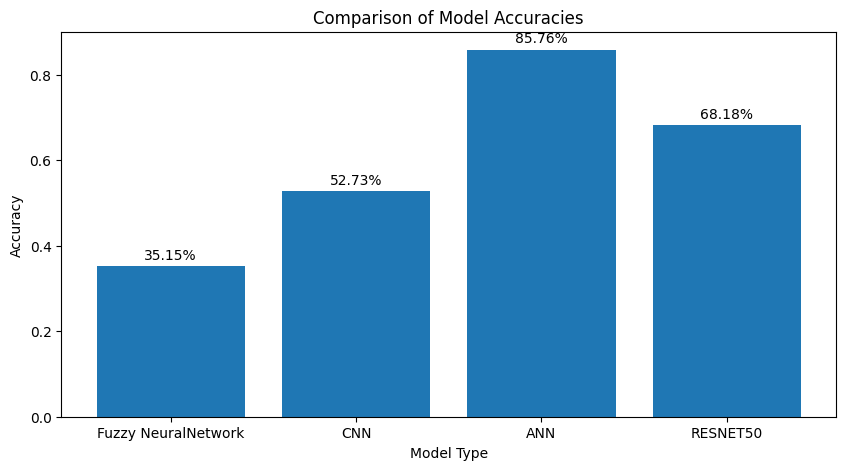

In [ ]:
models = ['Fuzzy NeuralNetwork', 'CNN', 'ANN','RESNET50']
accuracies = [accuracy_fcnn,accuracy_cnn, accuracy_ann,accuracy_resnet]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies)
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom')

plt.show()

Accuracy Comparision After optimzation

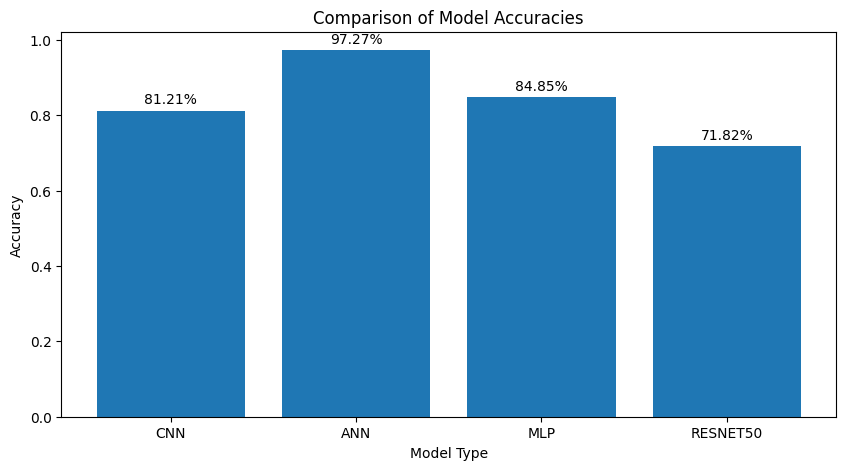

In [ ]:
models = [ 'CNN', 'ANN','MLP','RESNET50']
accuracies = [accuracy_cnn_opt, accuracy_ann_opt,accuracy_mlp,accuracy_resent_opt]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies)
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom')

plt.show()

Comparision of Losses accross different models

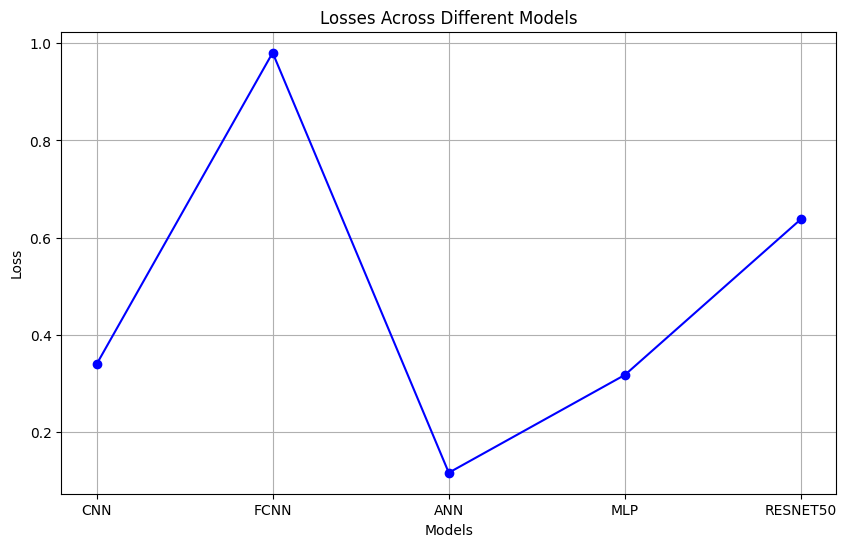

In [ ]:
models=["CNN","FCNN","ANN","MLP","RESNET50"]
losses=[loss_cnn_opt,loss_fcnn,loss_ann_opt,loss_mlp,loss_resnet_opt]
x_pos = list(range(len(models)))
plt.figure(figsize=(10, 6))
plt.plot(x_pos, losses, label='Model Losses', marker='o', linestyle='-', color='b')
plt.xticks(x_pos, models)

plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Losses Across Different Models')
plt.grid(True)
plt.show()